In [ ]:
# pip install ipywidgets
# pip install plotly
# pip install ipympl

In [ ]:
import os
import numpy as np
import pandas as pd
from typing import Any
from typing import Dict
from typing import List
import warnings

import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual, GridBox, Layout, VBox
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from data_encoder import DataEncoder

# Silence xgboost warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from keras.models import load_model


pd.set_option('display.max_columns', None)

%matplotlib inline
%matplotlib widget

# Dataset

In [ ]:
LAND_USE_COLS = ['c3ann', 'c3nfx', 'c3per', 'c4ann', 'pastr', 'range', 'secdf', 'secdn', 'urban']
DIFF_LAND_USE_COLS = [f"{col}_diff" for col in LAND_USE_COLS]
PRESCRIBED_LAND_USE_COLS = [f"{col}_prescribed" for col in LAND_USE_COLS]
OTHER_FEATURES_COLS = ['primf', 'primn', 'cell_area']
ALL_LAND_USE_COLS = ['primf', 'primn'] + LAND_USE_COLS
COLS_MAP = dict(zip(LAND_USE_COLS, DIFF_LAND_USE_COLS))

In [ ]:
CONTEXT_COLUMNS = ['c3ann', 'c3nfx', 'c3per', 'c4ann', 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area']
ACTION_COLUMNS = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff', 'c4ann_diff', 'pastr_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']
OUTCOME_COLUMNS = ['ELUC', 'Change']
CONTEXT_ACTION_COLUMNS = CONTEXT_COLUMNS + ACTION_COLUMNS

In [ ]:
DATASET_CSV = '../data/gcb/processed/uk_eluc.csv'
with open(DATASET_CSV) as df_file:
    data_source_df = pd.read_csv(df_file)

In [ ]:
data_source_df.tail()

# Code

In [ ]:
fields = {'lat': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 53.93974, 'range': [50.125, 58.625], 'std_dev': 2.2288961, 'sum': 4630295, 'valued': 'CONTINUOUS'},
          'lon': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -2.7644422, 'range': [-7.375, 1.625], 'std_dev': 1.9270877, 'sum': -237305.25, 'valued': 'CONTINUOUS'},
          'ELUC': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.021404957, 'range': [-1.2820702, 2.3366203], 'std_dev': 0.18355964, 'sum': -1837.4443, 'valued': 'CONTINUOUS'},
          'time': {'data_type': 'INT', 'has_nan': False, 'mean': 1936, 'range': [1851, 2021], 'std_dev': 49.362892, 'sum': 166190110, 'valued': 'CONTINUOUS'},
          'c3ann': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.2667192, 'range': [0, 1], 'std_dev': 0.19391803, 'sum': 22895.709, 'valued': 'CONTINUOUS'},
          'c3nfx': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.014878354, 'range': [0, 1], 'std_dev': 0.0128484, 'sum': 1277.1877, 'valued': 'CONTINUOUS'},
          'c3per': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00053631567, 'range': [0, 1], 'std_dev': 0.000610856, 'sum': 46.03841, 'valued': 'CONTINUOUS'},
          'c4ann': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.0063492954, 'range': [0, 1], 'std_dev': 0.0056106453, 'sum': 545.0362, 'valued': 'CONTINUOUS'},
          'i_lat': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 53.93974, 'range': [50.125, 58.625], 'std_dev': 2.2288961, 'sum': 4630295, 'valued': 'CONTINUOUS'},
          'i_lon': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -2.7644422, 'range': [-7.375, 1.625], 'std_dev': 1.9270877, 'sum': -237305.25, 'valued': 'CONTINUOUS'},
          'pastr': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.31008992, 'range': [0, 1], 'std_dev': 0.1939609, 'sum': 26618.738, 'valued': 'CONTINUOUS'},
          'primf': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 3.1008868e-10, 'range': [0, 1], 'std_dev': 1.2718036e-09, 'sum': 2.6618633e-05, 'valued': 'CONTINUOUS'},
          'primn': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 7.880206e-11, 'range': [0, 1], 'std_dev': 6.0690847e-10, 'sum': 6.7645265e-06, 'valued': 'CONTINUOUS'},
          'range': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.058702312, 'range': [0, 1], 'std_dev': 0.12839052, 'sum': 5039.124, 'valued': 'CONTINUOUS'},
          'secdf': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.18520375, 'range': [0, 1], 'std_dev': 0.19961607, 'sum': 15898.26, 'valued': 'CONTINUOUS'},
          'secdn': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.06774911, 'range': [0, 1], 'std_dev': 0.1195767, 'sum': 5815.7197, 'valued': 'CONTINUOUS'},
          'urban': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.030199211, 'range': [0, 1], 'std_dev': 0.06684742, 'sum': 2592.3606, 'valued': 'CONTINUOUS'},
          'ELUC_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00085764704, 'range': [-5, 5], 'std_dev': 0.091957845, 'sum': 73.62214, 'valued': 'CONTINUOUS'},
          'cell_area': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 45453.707, 'range': [40233.22, 49543.36], 'std_dev': 2439.213, 'sum': 3901837300, 'valued': 'CONTINUOUS'},
          'c3ann_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.0003815445, 'range': [-1, 1], 'std_dev': 0.0042161522, 'sum': -32.75254, 'valued': 'CONTINUOUS'},
          'c3nfx_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -2.3976065e-05, 'range': [-1, 1], 'std_dev': 0.00024510472, 'sum': -2.0581534, 'valued': 'CONTINUOUS'},
          'c3per_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -5.9571926e-07, 'range': [-1, 1], 'std_dev': 1.0220871e-05, 'sum': -0.05113773, 'valued': 'CONTINUOUS'},
          'c4ann_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -1.0171406e-05, 'range': [-1, 1], 'std_dev': 0.00010547795, 'sum': -0.8731338, 'valued': 'CONTINUOUS'},
          'pastr_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.0011081528, 'range': [-1, 1], 'std_dev': 0.0058669676, 'sum': 95.12605, 'valued': 'CONTINUOUS'},
          'range_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00036852885, 'range': [-1, 1], 'std_dev': 0.007347369, 'sum': 31.635254, 'valued': 'CONTINUOUS'},
          'secdf_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.00081145874, 'range': [-1, 1], 'std_dev': 0.008251627, 'sum': -69.65724, 'valued': 'CONTINUOUS'},
          'secdn_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.0005189244, 'range': [-1, 1], 'std_dev': 0.0052026906, 'sum': -44.54551, 'valued': 'CONTINUOUS'},
          'urban_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00026998913, 'range': [-1, 1], 'std_dev': 0.0007861656, 'sum': 23.176407, 'valued': 'CONTINUOUS'},
          'cell_area_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 45453.707, 'range': [40233.22, 49543.36], 'std_dev': 2439.213, 'sum': 3901837300, 'valued': 'CONTINUOUS'}}


In [ ]:
cao_mapping = {
    'context': ['lat', 'lon', 'time', 'c3ann', 'c3nfx', 'c3per', 'c4ann', 'i_lat', 'i_lon', 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area'],
    'actions': ['c3ann_diff', 'c3nfx_diff', 'c3per_diff', 'c4ann_diff', 'pastr_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff'],
    'outcomes': ['ELUC', 'Change']}

In [ ]:
encoder = DataEncoder(fields, cao_mapping)

In [ ]:
min_lat = data_source_df["i_lat"].min()
max_lat = data_source_df["i_lat"].max()
min_lon = data_source_df["i_lon"].min()
max_lon = data_source_df["i_lon"].max()
min_time = data_source_df["time"].min()
max_time = data_source_df["time"].max()

In [ ]:
def _is_single_action_prescriptor(actions):
    """
    Checks how many Actions have been defined in the Context, Actions, Outcomes mapping.
    :return: True if only 1 action is defined, False otherwise
    """
    return len(actions) == 1

def _is_scalar(prescribed_action):
    """
    Checks if the prescribed action contains a single value, i.e. a scalar, or an array.
    A prescribed action contains a single value if it has been prescribed for a single context sample
    :param prescribed_action: a scalar or an array
    :return: True if the prescribed action contains a scalar, False otherwise.
    """
    return prescribed_action.shape[0] == 1 and prescribed_action.shape[1] == 1

def _convert_to_nn_input(context_df: pd.DataFrame) -> List[np.ndarray]:
    """
    Converts a context DataFrame to a list of numpy arrays a neural network can ingest
    :param context_df: a DataFrame containing inputs for a neural network. Number of inputs and size must match
    :return: a list of numpy ndarray, on ndarray per neural network input
    """
    # The NN expects a list of i inputs by s samples (e.g. 9 x 299).
    # So convert the data frame to a numpy array (gives shape 299 x 9), transpose it (gives 9 x 299)
    # and convert to list(list of 9 arrays of 299)
    context_as_nn_input = list(context_df.to_numpy().transpose())
    # Convert each column's list of 1D array to a 2D array
    context_as_nn_input = [np.stack(context_as_nn_input[i], axis=0) for i in
                           range(len(context_as_nn_input))]
    return context_as_nn_input

In [ ]:
def prescribe_from_model(prescriptor, context_df: pd.DataFrame) -> Dict[str, Any]:
    """
    Generates prescriptions using the passed neural network candidate and context
    :param prescriptor: a Keras neural network
    ::param context_df: a DataFrame containing the context to prescribe for,
    :return: a dictionary of action name to action value or list of action values
    """
    action_list = ['recommended_land_use']
    
    # Convert the input df
    context_as_nn_input = _convert_to_nn_input(context_df)
    row_index = context_df.index
    
    # Get the prescrib?ed actions
    prescribed_actions = prescriptor.predict(context_as_nn_input)
    actions = {}

    if _is_single_action_prescriptor(action_list):
        # Put the single action in an array to process it like multiple actions
        prescribed_actions = [prescribed_actions]
            
    for i, action_col in enumerate(action_list):
        if _is_scalar(prescribed_actions[i]):
            # We have a single row and this action is numerical. Convert it to a scalar.
            actions[action_col] = prescribed_actions[i].item()
        else:
            actions[action_col] = prescribed_actions[i].tolist()
    
    # Convert the prescribed actions to a DataFrame
    prescribed_actions_df = pd.DataFrame(actions,
                                         columns=action_list,
                                         index=row_index)
    return prescribed_actions_df

In [ ]:
def compute_percent_changed(encoded_context_actions_df):
    # Sum the absolute values, but divide by 2 to avoid double counting
    # Because positive diff is offset by negative diff
    # context_action_df[DIFF_LAND_USE_COLS].abs().sum(axis=1) / 2

    encoded_context_actions_df = encoded_context_actions_df.reset_index(drop=True)
    # Decode in order to get the signed land usage diff values
    context_action_df = encoder.decode_as_df(encoded_context_actions_df)

    # Sum the positive diffs
    percent_changed = context_action_df[context_action_df[DIFF_LAND_USE_COLS] > 0].sum(axis=1)
    # Land usage is only a portion of that cell, e.g 0.8. Scale back to 1
    # So that percent changed really represent the percentage of change within the land use
    # portion of the cell
    # I.e. how much of the pie chart has changed?
    percent_changed = percent_changed / context_action_df[LAND_USE_COLS].sum(axis=1)
    df = pd.DataFrame(percent_changed, columns=['Change'])
    return df

In [ ]:
def run_prescriptor(prescriptor_model, sample_context_df):
    encoded_sample_context_df = encoder.encode_as_df(sample_context_df)
    prescribed_actions_df = prescribe_from_model(prescriptor_model, encoded_sample_context_df)
    reco_land_use_df = pd.DataFrame(prescribed_actions_df.recommended_land_use.tolist(),
                                columns=LAND_USE_COLS)
    
    # Assuming there's no primary land left in this cell
    # TODO: not correct. Need to account for primf and primn, that can't increase (no way to return to primary forest)
    prescribed_land_use_pct = reco_land_use_df.iloc[0][LAND_USE_COLS].sum() * 100
    print(f"Presribed land usage: {prescribed_land_use_pct:.2f}% of land")
    
    return reco_land_use_df.iloc[0].to_dict()

In [ ]:
def run_predictor(predictor_model, context, actions):
    # Parse
    actions = [a / 100 for a in actions]
    context_df = sample_context_df[CONTEXT_COLUMNS]
    actions_df = pd.DataFrame([actions], columns=LAND_USE_COLS)
    
    # Decode context and actions
    decoded_context = encoder.decode_as_df(context_df)
    decoded_actions = encoder.decode_as_df(actions_df)
    # Calculate diff
    for col in LAND_USE_COLS:
        decoded_context[col + "_diff"] = decoded_actions[col] - decoded_context[col]
    
    # Encode diff
    encoded_df = encoder.encode_as_df(decoded_context)
    
    # Reorder df
    encoded_df = encoded_df[CONTEXT_ACTION_COLUMNS]

    change_df = compute_percent_changed(encoded_df)
    print(f"Change: {change_df.iloc[0,0] * 100:.4f}%")
    
    # Pass into model
    new_pred = predictor_model.predict(encoded_df)
    pred_df = pd.DataFrame(new_pred, columns=["ELUC"])
    # Decode output
    out_df = encoder.decode_as_df(pred_df)
    return out_df.iloc[0, 0]

# Predictor

In [ ]:
predictor_model = XGBRegressor()
predictor_model.load_model("xgboost_predictor.json")

# Prescriptors
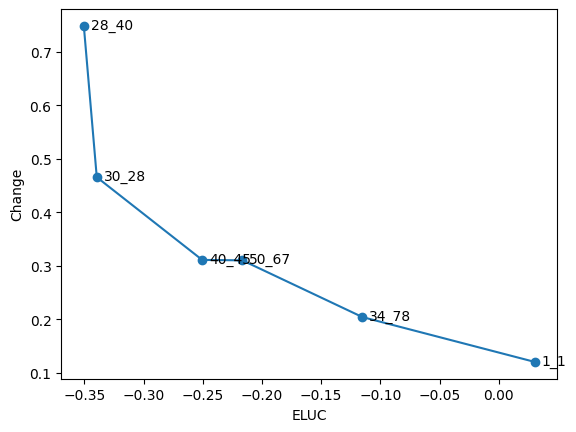

In [ ]:
PRESCRIPTOR_LIST = ["1_1", "34_78", "50_67", "40_45", "30_28", "28_40"]

# User Interface

In [ ]:
"""
Submits context and creates pie chart
Updates sliders for pie chart accordingly
#TODO: handle case where percentages don't sum to 1
"""

sample_context_df = None

out = widgets.Output()

def prescribe(b):
    prescriptor_model = load_prescriptor()
    prescribed = run_prescriptor(prescriptor_model, sample_context_df)

    for feature in LAND_USE_COLS:
        sliders[feature].value = prescribed[feature] * 100

    fig["data"] = (fig["data"][0], )
    
    # Clear figure and re-plot
    fig.add_trace(go.Pie(values=list(prescribed.values()), 
                     labels=LAND_USE_COLS, 
                     domain=dict(x=[0.5, 1]), 
                     title="Prescribed"), row=1, col=2)


"""
Locks a slider so it isn't affected by the sum to 100 computation
"""
def lock(change):
    if change["new"]:
        locked.add(change["owner"])
    else:
        locked.remove(change["owner"])


"""
Real-time updater for prescribed pie chart
# TODO: this breaks when a value hits 0
"""
def update_presc_plot(change):
    with fig.batch_update():
        if len(fig["data"]) > 1:
            fig["data"][1]["values"] = [slider.value for slider in sliders.values()]

"""
Submits context and actions and outputs prediction
"""
def predict(b):
    with out:
        context = sample_context_df
        actions = [slider.value for slider in sliders.values()]
        outcome = run_predictor(predictor_model, context, actions)
        print(f"ELUC: {outcome} tC/ha/yr")
        
def show_context(c):
    sample_df = data_source_df[(data_source_df.i_lat==latitude_input.value) & 
                           (data_source_df.i_lon==longitude_input.value) &
                           (data_source_df.time==time_input.value)]
    global sample_context_df
    sample_context_df = sample_df[CONTEXT_COLUMNS]
    # Plot initial context pie chart
    fig.add_trace(go.Pie(values=sample_context_df[LAND_USE_COLS].values[0],
                         labels=LAND_USE_COLS, 
                         domain=dict(x=[0, 0.5]), 
                         title="Current"), row=1, col=1)

def load_prescriptor():
    print(f"Selected prescriptor: {prescriptor_dropdown.value}")
    prescriptor_id = prescriptor_dropdown.value
    prescriptor_model_filename = os.path.join("prescriptors",
                                              prescriptor_id + '.h5')

    print(f'Loading prescriptor model: {prescriptor_model_filename}')
    prescriptor_model = load_model(prescriptor_model_filename, compile=False)
    return prescriptor_model
    
# Context
# Create the latitude input field
latitude_input = widgets.FloatText(description='Latitude:', value=51.625)

# Create the longitude input field
longitude_input = widgets.FloatText(description='Longitude:', value=-3.375)

# Create the time input field
time_input = widgets.IntText(description='Year:', value=2021)

"""
Construct widgets and attach them to their functions
TODO: handle unusable land
"""
sliders = {feature : widgets.FloatSlider(value=0.0, description="Prescribed " + feature, style=dict(description_width='initial')) for feature in LAND_USE_COLS}
ticks = {feature : widgets.Checkbox(value=False, description="Lock " + feature, style=dict(description_width='initial')) for feature in LAND_USE_COLS}

# For use in locking and unlocking sliders
locked = set()

prescribe_button = widgets.Button(description="Prescribe")
prescribe_button.on_click(prescribe)

predict_button = widgets.Button(description="Predict")
predict_button.on_click(predict)


"""
Display Interactables and Figures
TODO: add titles, make layout prettier
"""
fig = go.FigureWidget(make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]]))

# Context
context_range = f"Latitude must be between {min_lat} and {max_lat}, in 0.250 increments.\nLongitude must be between {min_lon} and {max_lon}, in 0.250 increments.\nYear must be between {min_time} and {max_time}."
text_area = widgets.Textarea(value=context_range,
                             rows=3,
                            layout=widgets.Layout(height="auto", width="auto"))
display(text_area)

display(latitude_input, longitude_input, time_input)

show_context_button = widgets.Button(description="Show land use")
show_context_button.on_click(show_context)
display(show_context_button)

# Prescribe
prescriptor_label = widgets.Label('Select a prescriptor:')
prescriptor_dropdown = widgets.Dropdown(options=PRESCRIPTOR_LIST)
display(prescriptor_label, prescriptor_dropdown)

display(prescribe_button)

# Initial land usage | Prescribed land usage
display(fig)

# Sliders
for feat in sliders:
    sliders[feat].observe(update_presc_plot, names="value")
    ticks[feat].observe(lock, names="value")
    display(sliders[feat], ticks[feat])

# Predict
display(predict_button, out)